In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

import math
import time
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
#print(os.getcwd())

In [3]:
#data = web.get_data_yahoo("BTC-USD", start = "2015-01-01", end = "2021-06-22")

In [4]:
#data.head(5)
#data[-5:]

In [5]:
#data.to_csv("BTC-updated.csv")

In [6]:
BTC_data_file="BTC-updated.csv"

In [7]:
# Fixing seed for same results
np.random.seed(100)

In [8]:
# Loading dataset from csv file
df = pd.read_csv(BTC_data_file, header = None, index_col = None, delimiter=',')

In [9]:
df.head(5)
df[-5:]

,0,1,2,3,4,5,6
2357,6/17/2021,38187.26172,35255.85547,38099.47656,35787.24609,36200887275,35787.24609
2358,6/18/2021,36457.79688,34933.0625,35854.52734,35615.87109,31207279719,35615.87109
2359,6/19/2021,36059.48438,33432.07422,35563.14063,35698.29688,36664034054,35698.29688
2360,6/21/2021,35687.85938,32721.39453,35687.85938,32930.03125,43962011648,32930.03125
2361,6/22/2021,31631.47852,31235.7832,31432.66992,31631.47852,5.35E+10,31631.47852


In [10]:
# Here, we only take the closing-prices for the dataset (column_index[4])

input = df[4].values                            ## values
input = input[1:]
data_array = input.reshape(-1, 1)               ## array

print(data_array)

[['314.2489929']
 ['315.0320129']
 ['281.0820007']
 ...
 ['35698.29688']
 ['32930.03125']
 ['31631.47852']]


In [11]:
# Testing
train_data_size = int(len(data_array) * 0.9)                                                                                ### train-data size
test_data_size = len(data_array) - train_data_size                                                                          ### test-data size
train_data, test_data = data_array[0:train_data_size, :], data_array[train_data_size:len(data_array), :]

In [12]:
# Testing if the dataserts are properly made.
print(train_data)
print(".....................")
print(test_data)

[['314.2489929']
 ['315.0320129']
 ['281.0820007']
 ...
 ['13075.24805']
 ['13654.21875']
 ['13271.28516']]
.....................
[['13437.88281']
 ['13546.52246']
 ['13780.99512']
 ['13737.10938']
 ['13550.48926']
 ['13950.30078']
 ['14133.70703']
 ['15579.84863']
 ['15565.88086']
 ['14833.75391']
 ['15479.56738']
 ['15332.31543']
 ['15290.90234']
 ['15701.33984']
 ['16276.34375']
 ['16317.80859']
 ['16068.13867']
 ['15955.58789']
 ['16716.11133']
 ['17645.40625']
 ['17804.00586']
 ['17817.08984']
 ['18621.31445']
 ['18642.23242']
 ['18370.00195']
 ['18364.12109']
 ['19107.46484']
 ['18732.12109']
 ['17150.62305']
 ['17108.40234']
 ['17717.41406']
 ['18177.48438']
 ['19625.83594']
 ['18802.99805']
 ['19201.0918']
 ['19445.39844']
 ['18699.76563']
 ['19154.23047']
 ['19345.12109']
 ['19191.63086']
 ['18321.14453']
 ['18553.91602']
 ['18264.99219']
 ['18058.9043']
 ['18803.65625']
 ['19142.38281']
 ['19246.64453']
 ['19417.07617']
 ['21310.59766']
 ['22805.16211']
 ['23137.96094']
 ['23

In [13]:
# Normalizing the dataset within 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data_array)

In [14]:
print(dataset)
#print(len(dataset))
print("............................")
print(dataset[:,0])

[[0.00214994]
 [0.00216231]
 [0.00162619]
 ...
 [0.56091584]
 [0.51720087]
 [0.49669482]]
............................
[0.00214994 0.00216231 0.00162619 ... 0.56091584 0.51720087 0.49669482]


In [15]:
# Splitting the dataset into training and test sets, based on a percentage. Here we take 90% train and 10% as test dataset
training_data_size = int(len(dataset) * 0.9)                                                            # 0.5, 0.6, 0.7, 0.8
testing_data_size = len(dataset) - training_data_size
training_data, testing_data = dataset[0:training_data_size,:], dataset[training_data_size:len(dataset),:]

In [16]:
# Creating a matrix for X and Y values from an array, with a certain lookback period
def create_dataset(dataset, look_back=7):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i : (i+look_back), 0]
		dataX.append(x)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# Based on the look-back period, we make a rollling window for iterations
look_back = 7                                                           # 7 days lookback; 1 day
trainX, trainY = create_dataset(training_data, look_back)               # Creating Datasets
testX, testY = create_dataset(testing_data, look_back)

In [18]:
print(trainX)
print("..................................................................")
print(trainY)

[[0.00214994 0.00216231 0.00162619 ... 0.00152184 0.00170684 0.00183551]
 [0.00216231 0.00162619 0.00135952 ... 0.00170684 0.00183551 0.00166199]
 [0.00162619 0.00135952 0.00152184 ... 0.00183551 0.00166199 0.00177346]
 ...
 [0.17852654 0.18261144 0.18536386 ... 0.20193789 0.20139542 0.20418298]
 [0.18261144 0.18536386 0.19969231 ... 0.20139542 0.20418298 0.2029688 ]
 [0.18536386 0.19969231 0.20193789 ... 0.20418298 0.2029688  0.20366479]]
..................................................................
[0.00166199 0.00177346 0.00152692 ... 0.2029688  0.20366479 0.21280759]


In [19]:
# Reshaping input data to 3 Dimensions
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
### LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))           # input_shape=(None, look_back); units = 25, 50 better so far (10 not good) (100 about same as 25)
model.add(Dropout(0.01))                                                           # 0.1 # 0.01 gives better results # 0.001 is not any better from 0.01
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs_var = 100                                                                              ### 50, or 100
history = model.fit(trainX, trainY, epochs=epochs_var, batch_size=8, verbose=1)               ### batch_size=64; batch_size=8 gives better results

Epoch 1/100
265/265 [==============================] - 28s 3ms/step - loss: 0.0224
Epoch 2/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 3/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 4/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 5/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 6/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 7/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 8/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0032
Epoch 9/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 10/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 11/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0031
Epoch 12/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 13/100

In [23]:
model.evaluate(trainX, trainY, verbose=1)
model.evaluate(testX, testY, verbose=1)

8/8 [==============================] - 0s 2ms/step - loss: 0.0483


0.04830120503902435

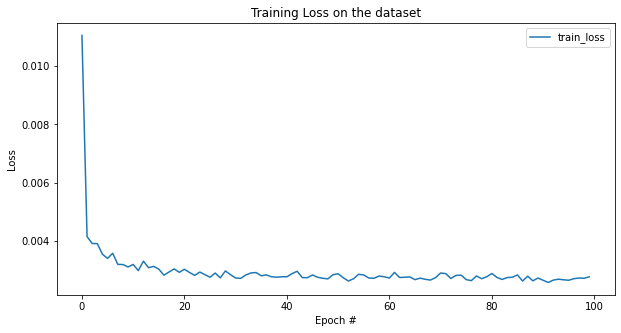

In [24]:
# Plot
N = epochs_var

plt.figure(figsize=(10,5))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")

plt.title("Training Loss on the dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

In [25]:
# Now let's make predictions from the model
train_Predictions = model.predict(trainX)                                            # Predictions for training data
test_Predictions = model.predict(testX)                                              # Predictions for test data


In [26]:
# Invert-scale predictions
train_Predictions = scaler.inverse_transform(train_Predictions)                                         ### Train Predictions
trainY = scaler.inverse_transform([trainY])                                                             ### Actual Prices

test_Predictions = scaler.inverse_transform(test_Predictions)                                          ### Test Predictions
testY = scaler.inverse_transform([testY])                                                               ### Actual Prices

In [27]:
print(test_Predictions[:,0])
print(".........................................")
print(testY[0])

[14007.789  15261.633  15469.904  14818.044  15226.869  15238.801
 15155.383  15463.809  16047.492  16162.7705 15929.041  15790.369
 16433.344  17349.5    17606.176  17606.406  18298.633  18442.098
 18164.404  18085.256  18745.223  18526.404  17069.92   16785.771
 17367.498  17874.535  19160.732  18680.621  18877.63   19139.26
 18543.172  18758.725  19014.184  18920.432  18107.219  18191.605
 18009.273  17787.006  18388.932  18832.738  18961.482  19099.553
 20786.074  22373.865  22815.045  23409.65   23145.473  22433.37
 23127.416  22809.963  23119.838  23993.703  25735.367  25771.285
 26381.98   26702.78   28019.346  28259.693  28531.072  30968.842
 31903.818  31068.479  32613.47   35459.867  37939.62   39224.55
 38685.336  36669.2    33765.617  31926.314  34876.86   37173.81
 35232.977  34257.133  34033.223  34779.137  34257.984  33752.195
 29539.123  30962.67   30630.154  30790.582  30830.898  31266.482
 29366.383  30153.861  32811.38   33136.223  31883.178  32101.578
 34007.605  35

In [28]:
### Testing
#print(len(testY))
print(trainY)
print(".........................................")
print(testY)
print("************************************************************")
print(train_Predictions)
print(".........................................")
print(test_Predictions)

[[  283.348999    290.4079895   274.79599   ... 13031.17383
  13075.24805   13654.21875  ]]
.........................................
[[15579.84863 15565.88086 14833.75391 15479.56738 15332.31543 15290.90234
  15701.33984 16276.34375 16317.80859 16068.13867 15955.58789 16716.11133
  17645.40625 17804.00586 17817.08984 18621.31445 18642.23242 18370.00195
  18364.12109 19107.46484 18732.12109 17150.62305 17108.40234 17717.41406
  18177.48438 19625.83594 18802.99805 19201.0918  19445.39844 18699.76563
  19154.23047 19345.12109 19191.63086 18321.14453 18553.91602 18264.99219
  18058.9043  18803.65625 19142.38281 19246.64453 19417.07617 21310.59766
  22805.16211 23137.96094 23869.83203 23477.29492 22803.08203 23783.0293
  23241.3457  23735.94922 24664.79102 26437.03711 26272.29492 27084.80859
  27362.4375  28840.95313 29001.7207  29374.15234 32127.26758 32782.02344
  31971.91406 33992.42969 36824.36328 39371.04297 40797.60938 40254.54688
  38356.44141 35566.65625 33922.96094 37316.35938 391

In [29]:
# Calculating errors - Root-Mean-Squared error and the Mean-Absolute error
trainScore_rmse = math.sqrt(mean_squared_error(trainY[0], train_Predictions[:,0]))
trainScore_mae = mean_absolute_error(trainY[0], train_Predictions[:,0])
print(f"Train Score: {trainScore_rmse} RMSE")
print(f"Train Score: {trainScore_mae} MAE")
testScore_rmse = math.sqrt(mean_squared_error(testY[0], test_Predictions[:,0]))
testScore_mae = mean_absolute_error(testY[0], test_Predictions[:,0])
print(f"Test Score: {testScore_rmse} RMSE")
print(f"Test Score: {testScore_mae} MAE")

Train Score: 299.27278754404546 RMSE
Train Score: 162.56167643714429 MAE
Test Score: 3939.0337920682755 RMSE
Test Score: 3058.690856451965 MAE


In [30]:
# Arranging train predictions for plotting
train_Predictions_Plot = np.empty_like(dataset)
train_Predictions_Plot[:, :] = np.nan
train_Predictions_Plot[look_back:len(train_Predictions)+look_back, :] = train_Predictions

In [31]:
# Arranging test predictions for plotting
test_Predictions_Plot = np.empty_like(dataset)
test_Predictions_Plot[:, :] = np.nan
test_Predictions_Plot[len(train_Predictions)+(look_back*2)+1:len(dataset)-1, :] = test_Predictions 

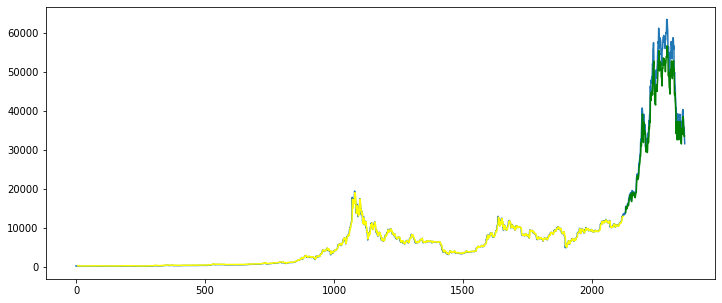

In [32]:
# plot baseline and predictions
# plot the actual price (blue), predictions in the training data=yellow, predictions in test data=green
plt.figure(figsize=(12,5))

plt.plot(scaler.inverse_transform(dataset))                                  ### Actual Prices

plt.plot(train_Predictions_Plot, 'yellow')                                   ### Train Predictions

plt.plot(test_Predictions_Plot, 'green')                                     ### Test Predictions

plt.show()

In [33]:
print('testPrices:')                                                                ### Actual Prices (all data points)
testPrices = testY[0]
print(testPrices)

print('testPredictions:')                                                           ### Predictions (10& of the data - lookback_size)
print(test_Predictions) 

testPrices:
[15579.84863 15565.88086 14833.75391 15479.56738 15332.31543 15290.90234
 15701.33984 16276.34375 16317.80859 16068.13867 15955.58789 16716.11133
 17645.40625 17804.00586 17817.08984 18621.31445 18642.23242 18370.00195
 18364.12109 19107.46484 18732.12109 17150.62305 17108.40234 17717.41406
 18177.48438 19625.83594 18802.99805 19201.0918  19445.39844 18699.76563
 19154.23047 19345.12109 19191.63086 18321.14453 18553.91602 18264.99219
 18058.9043  18803.65625 19142.38281 19246.64453 19417.07617 21310.59766
 22805.16211 23137.96094 23869.83203 23477.29492 22803.08203 23783.0293
 23241.3457  23735.94922 24664.79102 26437.03711 26272.29492 27084.80859
 27362.4375  28840.95313 29001.7207  29374.15234 32127.26758 32782.02344
 31971.91406 33992.42969 36824.36328 39371.04297 40797.60938 40254.54688
 38356.44141 35566.65625 33922.96094 37316.35938 39187.32813 36825.36719
 36178.14063 35791.27734 36630.07422 36069.80469 35547.75    30825.69922
 33005.76172 32067.64258 32289.37891 323

In [34]:
print(len(testPrices))
print(len(test_Predictions))

229
229


In [35]:
# export prediction and actual prices
#df = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df1 = pd.DataFrame(data={"prediction": np.around(list(test_Predictions.reshape(-1)), decimals=2)})
df2 = pd.DataFrame(data={"test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df1.to_csv("lstm_result_new_BTC_1.csv", sep=';', index=None)
df2.to_csv("lstm_result_new_BTC_2.csv", sep=';', index=None)